In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:

train_dir = 'chest_xray/train'
validation_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Using ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)



In [3]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [5]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
class_weights = {0: 1.0, 1: 2.0}
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
      class_weight=class_weights
)

c:\Users\MolenGeek\Documents\Projet_pneumonia\.conda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
163/163 [==============================] - 1770s 11s/step - loss: 0.4996 - accuracy: 0.7465 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 1839s 11s/step - loss: 0.3888 - accuracy: 0.7995 - val_loss: 0.6363 - val_accuracy: 0.5625
Epoch 3/5
163/163 [==============================] - 1616s 10s/step - loss: 0.3285 - accuracy: 0.8687 - val_loss: 0.6228 - val_accuracy: 0.5625
Epoch 4/5
163/163 [==============================] - 1488s 9s/step - loss: 0.2914 - accuracy: 0.8926 - val_loss: 0.6482 - val_accuracy: 0.5625
Epoch 5/5
163/163 [==============================] - 1468s 9s/step - loss: 0.2659 - accuracy: 0.9038 - val_loss: 0.6503 - val_accuracy: 0.6250


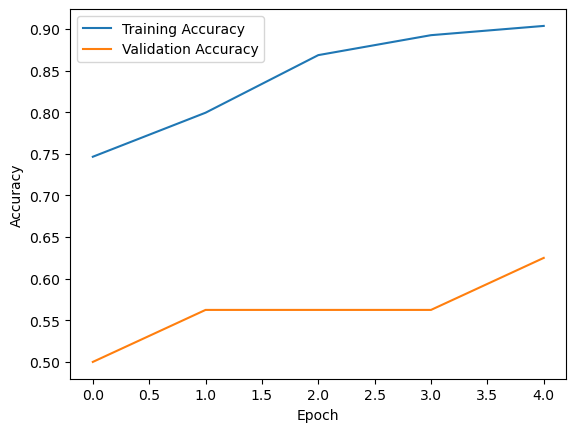

20/20 [==============================] - 200s 10s/step - loss: 0.4359 - accuracy: 0.7708
Test Accuracy: 0.7708333134651184
20/20 [==============================] - 226s 11s/step


In [6]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Accuracy: {test_acc}')

# Get predictions
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = test_generator.classes

In [7]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, target_names=class_labels))

Confusion Matrix:
[[234   0]
 [390   0]]
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



c:\Users\MolenGeek\Documents\Projet_pneumonia\.conda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MolenGeek\Documents\Projet_pneumonia\.conda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MolenGeek\Documents\Projet_pneumonia\.conda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif